In [26]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import joblib
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')



In [37]:
!pip install umap


  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=161c1f5bf41413515a7b8ed6e2b9cb3b20b51357878140f5b888674c58002ac1
  Stored in directory: /Users/arthur/Library/Caches/pip/wheels/df/22/c9/3de2d976b162d3f90c60ed7e415f344d0630518a501093e7b1
Successfully built umap


In [51]:
!pip install umap-learn==0.3.10


     |████████████████████████████████| 40 kB 8.4 MB/s  eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.3.10-py3-none-any.whl size=38881 sha256=6210217ea61eb1b7d5952235aa847811d1f1976fcbe29714f1b05161480bbe56
  Stored in directory: /Users/arthur/Library/Caches/pip/wheels/1b/69/69/91e19c0578b1740a6358f5db2c2dcc5af5b04360c3c9066b26
Successfully built umap-learn
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.7
    Uninstalling umap-learn-0.5.7:
      Successfully uninstalled umap-learn-0.5.7


In [47]:
import seaborn as sns
from sklearn.decomposition import KernelPCA
import umap


AttributeError: module 'umap' has no attribute '__version__'

In [52]:
import pkg_resources
print("UMAP version:", pkg_resources.get_distribution("umap-learn").version)


UMAP version: 0.3.10


In [55]:
import umap
print(dir(umap))  # List all functions and classes inside umap


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [38]:

# 📌 Load dataset
filename = "/Users/arthur/Documents/GITHUB/Rough_informer/Rough_Informer_for_High_freq_Order_Book/Sig_global_local_level_by_level_depth-2_row_50000.csv"
df = pd.read_csv(filename)

# 📌 Feature Engineering: Add Sine & Cosine Transformations for Periodic Features
if 'time_step' in df.columns:
    df['sin_time'] = np.sin(2 * np.pi * df['time_step'] / max(df['time_step']))
    df['cos_time'] = np.cos(2 * np.pi * df['time_step'] / max(df['time_step']))
    print(" Sine and Cosine features added.")

# 📌 Separate Features and Target
X = df.drop(columns=['y', 'time_step']).values  # Drop target & time metadata
y = df['y'].values

# 📌 Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



✅ Sine and Cosine features added.


In [56]:
# ============================
# 🔹 Kernel PCA (with RBF Kernel)
# ============================
n_components_kpca = 50  # Adjust the number of components
kpca = KernelPCA(n_components=n_components_kpca, kernel='rbf', gamma=0.1)  # 'gamma' controls kernel sensitivity
X_kpca = kpca.fit_transform(X_scaled)

print(f"✅ Kernel PCA applied with {n_components_kpca} components.")

plt.figure(figsize=(10, 5))

# Kernel PCA Visualization
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_kpca[:, 0], y=X_kpca[:, 1], hue=y, palette="viridis", alpha=0.5)
plt.title("Kernel PCA (First 2 Components)")
plt.xlabel("KPCA 1")
plt.ylabel("KPCA 2")


KeyboardInterrupt: 

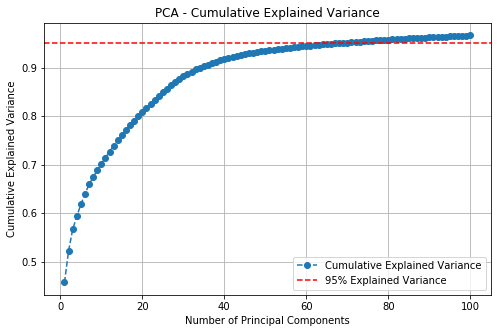

In [35]:
# Apply PCA
n_components = 100  # Change this to the number of components you want
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--', label="Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend()
plt.grid()
plt.show()

In [ ]:

# Replace train_test_split with:
split_2 = int(len(df) * 0.8)
split_1 = int(len(df) * 0.6)
X_train, X_test, X_val = X_scaled[:split_1], X_scaled[split_1:split_2],X_scaled[split_2:]
y_train, y_test,y_val = y[:split_1], y[split_1:split_2], y[split_2:]

In [22]:
import pandas as pd

# Load the original dataset
original_data = pd.read_csv('/Users/arthur/Documents/STUDY/Imperial/rough paths /salvi notebook/data.csv.gz', compression='gzip', nrows=500000)
original_y = original_data.iloc[:, -1].values  # Assuming 'y' is the last column

# Load the generated dataset
dataset = df

# Verify the match between 'y' values
mismatches = []
for index, row in dataset.iterrows():
    time_step = int(row['time_step'])  # Ensure the time_step is an integer
    test_y = row['y']

    # Check if time_step is within the bounds of the original dataset
    if time_step < len(original_y):
        original_y_value = original_y[time_step]
        if test_y != original_y_value:
            mismatches.append((index, time_step, test_y, original_y_value))
    else:
        mismatches.append((index, time_step, test_y, 'Out of bounds'))

# Display the mismatches
if mismatches:
    print(f"Found {len(mismatches)} mismatches:")
    for mismatch in mismatches[:10]:  # Display first 10 mismatches
        print(f"Index {mismatch[0]}: time_step={mismatch[1]}, test_y={mismatch[2]}, original_y={mismatch[3]}")
else:
    print("All 'y' values match correctly.")


All 'y' values match correctly.


In [23]:
print("X_train", X_train.shape)
print("X_val", X_val.shape)
print("y_train", y_train.shape)
print("y_val", y_val.shape)

X_train (30000, 1896)
X_val (10000, 1896)
y_train (30000,)
y_val (10000,)


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')


In [7]:
# ===============================
# 2️⃣ Elastic Net Regression Model
# ===============================

# Initialize and train Elastic Net model
elastic_net = ElasticNet(alpha=0.3, l1_ratio=0.3, random_state=42)
elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = elastic_net.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Print R² score
print(f"R² Score on Validation Set: {r2:.4f}")

R² Score on Validation Set: -0.0022


In [9]:

# ===============================
# 2️⃣ Hyperparameter Tuning with Hyperopt
# ===============================

param_space = {
    'boosting_type': hp.choice('boosting_type', ['dart']),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.6),
    'drop_rate': hp.uniform('drop_rate', 0.2, 0.9),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'max_depth': hp.choice('max_depth', [ 5, 6,7,8,9,10]),
    'min_child_samples': hp.randint('min_child_samples', 100, 400),
    'min_child_weight': hp.uniform('min_child_weight', 0.01, 0.05),
    'n_estimators': hp.choice('n_estimators', [900,1200,1500,2000,2500,3000]),
    'objective': 'regression',
    'skip_drop': hp.uniform('skip_drop', 0.3, 0.7),
    'subsample': hp.uniform('subsample', 0.2, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    
}

def train_lgb_model(params, X_train, y_train, X_test, y_test, seed=42):
    """Train LightGBM and return (model, R^2, RMSE) on validation."""
    
    # Add additional parameters
    params.update({
        'random_state': seed,    
        'verbosity': -1,          # Suppresses output
        'n_jobs': -1              # Uses all CPU cores
    })
    model = lgb.LGBMRegressor(**params)
    
    
    # Correct way to pass early stopping
    model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='r2',  # Use MSE for early stopping
    callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)])
    
    y_test_pred = model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    return model, r2_test, rmse_test


def objective_func(space):
    _, r2_test, rmse_test = train_lgb_model(space, X_train, y_train, X_test, y_test)
    return {'loss': 1.0 - r2_test, 'status': STATUS_OK}

# Hyperparameter Optimization
trials = Trials()
best_params = fmin(
    fn=objective_func,
    space=param_space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(42)
)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

[1]	valid_0's l2: 1.3696                              
[2]	valid_0's l2: 1.36975                             
[3]	valid_0's l2: 1.36989                             
[4]	valid_0's l2: 1.37002                             
[5]	valid_0's l2: 1.36997                             
[6]	valid_0's l2: 1.37012                             
[7]	valid_0's l2: 1.37023                             
[8]	valid_0's l2: 1.37015                             
[9]	valid_0's l2: 1.3698                              
[10]	valid_0's l2: 1.36958                            
[11]	valid_0's l2: 1.36971                            
[12]	valid_0's l2: 1.36953                            
[13]	valid_0's l2: 1.36965                            
[14]	valid_0's l2: 1.36954                            
[15]	valid_0's l2: 1.3697                             
[16]	valid_0's l2: 1.36957                            
[17]	valid_0's l2: 1.36947                            
[18]	valid_0's l2: 1.36959                            
[19]	valid

In [10]:
# Map the indices to actual values
best_params['n_estimators'] = [900,1200,1500,2000,2500,3000][best_params['n_estimators']]




In [11]:
best_params['max_depth']=[ 5, 6,7,8,9,10][best_params['max_depth']]

In [13]:
best_params['boosting_type'] = ['dart'][best_params['boosting_type']]


In [14]:
print(best_params)

{'boosting_type': 'dart', 'colsample_bytree': 0.5445230904341876, 'drop_rate': 0.5098056715332502, 'learning_rate': 0.010509599317067317, 'max_depth': 5, 'min_child_samples': 133, 'min_child_weight': 0.019900995696162563, 'n_estimators': 2000, 'reg_alpha': 0.9739479466464522, 'reg_lambda': 0.017096689947744492, 'skip_drop': 0.6622926542536769, 'subsample': 0.3859685099756776}


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import joblib
import warnings

warnings.filterwarnings('ignore')

# ===============================
# 1️⃣ Data Loading & Preprocessing
# ===============================

# Load the dataset
filename = "/Users/arthur/Documents/GITHUB/Rough_informer/Rough_Informer_for_High_freq_Order_Book/final_dataset_depth-2_row_10_000.csv"
df = pd.read_csv(filename)

# Separate features and target
X = df.drop(columns=['y', 'time_step']).values  # Drop 'time_step' as it's metadata
y = df['y'].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Replace train_test_split with:
split_idx = int(len(df) * 0.8)
X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]
print(X.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/arthur/Documents/GITHUB/Rough_informer/Rough_Informer_for_High_freq_Order_Book/final_dataset_depth-2_row_10_000.csv'

In [18]:
print("X_train", X_train.shape)
print("X_val", X_val.shape)
print("y_train", y_train.shape)
print("y_val", y_val.shape)

X_train (8000, 1260)
X_val (2000, 1260)
y_train (8000,)
y_val (2000,)


In [24]:


# ===============================
# 3️⃣ Final Model Training
# ===============================



# Train the final model
final_model, final_r2, final_rmse = train_lgb_model(best_params, X_train, y_train, X_val, y_val)

# Save the model
joblib.dump(final_model, 'lgb_model_final.joblib')

# ===============================
# 4️⃣ Evaluation
# ===============================

print(f"Final R² on Validation Set: {final_r2:.4f}")
print(f"Final RMSE on Validation Set: {final_rmse:.4f}")


[1]	valid_0's l2: 0.735403
[2]	valid_0's l2: 0.735227
[3]	valid_0's l2: 0.73532
[4]	valid_0's l2: 0.735407
[5]	valid_0's l2: 0.735358
[6]	valid_0's l2: 0.734932
[7]	valid_0's l2: 0.734907
[8]	valid_0's l2: 0.735009
[9]	valid_0's l2: 0.734819
[10]	valid_0's l2: 0.734868
[11]	valid_0's l2: 0.73492
[12]	valid_0's l2: 0.734769
[13]	valid_0's l2: 0.734564
[14]	valid_0's l2: 0.734587
[15]	valid_0's l2: 0.734502
[16]	valid_0's l2: 0.734428
[17]	valid_0's l2: 0.734406
[18]	valid_0's l2: 0.734536
[19]	valid_0's l2: 0.734406
[20]	valid_0's l2: 0.734888
[21]	valid_0's l2: 0.734869
[22]	valid_0's l2: 0.734834
[23]	valid_0's l2: 0.734763
[24]	valid_0's l2: 0.734656
[25]	valid_0's l2: 0.734817
[26]	valid_0's l2: 0.734794
[27]	valid_0's l2: 0.734839
[28]	valid_0's l2: 0.734669
[29]	valid_0's l2: 0.734664
[30]	valid_0's l2: 0.734614
[31]	valid_0's l2: 0.734674
[32]	valid_0's l2: 0.734654
[33]	valid_0's l2: 0.734388
[34]	valid_0's l2: 0.734386
[35]	valid_0's l2: 0.734316
[36]	valid_0's l2: 0.734282
[37